For this project, you will interpret data from the National Parks Service about endangered species in different parks.

You will perform some data analysis on the conservation statuses of these species and investigate if there are any patterns or themes to the types of species that become endangered. During this project, you will analyze, clean up, and plot data as well as pose questions and seek to answer them in a meaningful way.

After you perform your analysis, you will share your findings about the National Park Service.

Scoping Project

1) Import and review data for project
2) Analyze the data and begin to develop questions
3) Conduct analysis to answer the questions posed above
4) Summarize the findings of your answers to these questions

In [122]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [123]:
# ingest raw data
obs_df = pd.read_csv('observations.csv', skipinitialspace=True)
spec_df = pd.read_csv('species_info.csv', skipinitialspace=True)

# clean up data frames

''' We see multiple recorded observations for one location and species type (ex: Echinochloa crus-galli @ 
Bryce has obs of 112 and 116). To err on the side of caution, this report is going to be considering the 
lowest of all of the values for specific species/ location combinations (e.g: 112 from the above example.)'''

# sort by the number of observations (smaller first), then keep smallest of duplicates
obs_df = obs_df.sort_values('observations', ascending=True).drop_duplicates(['scientific_name', 'park_name'], keep= 'first').sort_index() # from https://stackoverflow.com/questions/12497402/remove-duplicates-by-columns-a-keeping-the-row-with-the-highest-value-in-column/68876659#68876659


''' We also see multiple duplicates in the species information. Upon review, we have multiple common names 
and conservation statuses for a single species (ex: Canis lupus is both endangered and in recovery). In a 
similar approch, this analysis will bias towards caution -- marking a species as Endangered rather than 
In Recovery when there is a conflict. All common names have been combined to keep their values intact.'''

# combine all common names for each scientific name
spec_names = spec_df.groupby(['scientific_name'])['common_names'].apply(', '.join).reset_index() # from https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby

# assign all common names back to species data frame
spec_df = pd.merge(spec_df, spec_names, on= 'scientific_name', how= 'left')

# drop old common names column
spec_df = spec_df.drop(columns= 'common_names_x')

# rename new common names column
spec_df.rename(columns= {'common_names_y': 'common_names'}, errors="raise", inplace= True)

# remove redundant names from common names column
spec_df['common_names'] = spec_df['common_names'].str.replace(' ,', ',')
spec_df['common_names'] = spec_df['common_names'].str.replace(', ', ',')
spec_df['common_names']=spec_df['common_names'].str.split(',').apply(lambda x : ', '.join(set(x)))

# encode data to enable sorting by conservation status for duplicates (Endangered > Threatened > Species of Concern > In Recovery > None)
spec_df['conservation_status'] = spec_df['conservation_status'].replace(np.nan, 'None')
spec_df['conservation_group'] = pd.Categorical(spec_df['conservation_status'], ordered=True, categories=['None', 'In Recovery', 'Species of Concern', 'Threatened', 'Endangered'])

# drop duplicate species keeping the most conservative level in conservation group
spec_df = spec_df.sort_values('conservation_group', ascending=True).drop_duplicates(['scientific_name'], keep= 'last')

# drop column used for sorting
spec_df = spec_df.drop('conservation_group', 1)
spec_df.to_csv('spec_df.csv')

# combine all data into single data frame
bio_df = pd.merge(spec_df, obs_df, on= 'scientific_name', how= 'left')

# confirm merge using original csvs # confirmed
# bio_df[bio_df['conservation_status'] == 'Endangered'].head(10)

bio_df.head()
bio_df.to_csv('bio_df.csv')
bio_df.describe(include='all')

bio_df_troubled = bio_df.loc[bio_df['conservation_status'] != 'None']

bio_df_troubled_renamed_parks = bio_df_troubled.replace({'Bryce National Park': 'Bryce', 
                                                         'Great Smoky Mountains National Park': 'Great Smoky Mountains', 
                                                         'Yosemite National Park': 'Yosemite', 
                                                         'Yellowstone National Park': 'Yellowstone'})

#### Data

I should describe the errata in the data more.

After cleaning the data, there are 22,164 observations with 5,541 scientific names (5,236 lists of common names). Observations of these species span 7 categories, 5 conservation statuses, and 4 parks. The bulk of the species (96.8%) are in no conservation group (meaning they are not a in recovery, a species of concern, threatened, or endangered). Of those which are in a group (do have a conservation status); 12 (0.1%) are in recovery, 604 (2.7%) are species of concern, 40 (0.2%) are threatened, and 60 (0.3%) are endangered.

The most common category was vascular plants at 76.9% of the species, followed by birds at 8.8%. Nonvascular plants made up 6.0% of the species, with the remaining four categories (mammal, fish, amphibian, and reptile) constituting the remaining 8.3%.

The median number of all obeservations across all species and parks is 124, with a minimum of 9, and a maximum of 321.

# Charting

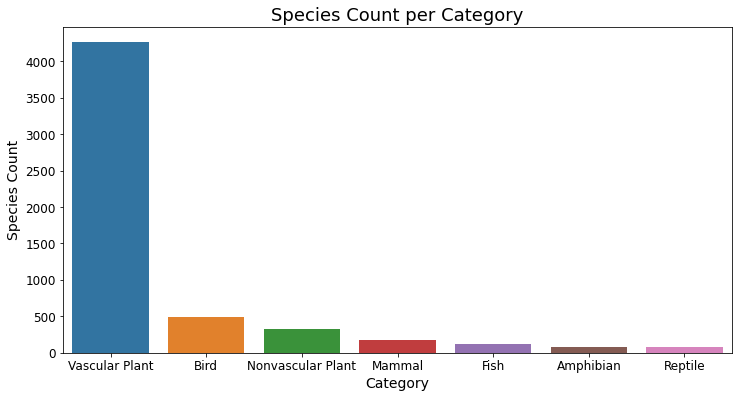

In [124]:
# count species by category
# category_species_count = bio_df.groupby(['category'])[['scientific_name']].count()
# the above doesn't work as all species are accounted for in each park. in order to get the true number, we would have
# to divide the count by 4, or groupby on the spec_df dataset. the latter feels better than using a scalar.

category_species_count = spec_df.groupby('category')[['scientific_name']].count()
category_species_count.rename({'scientific_name': 'scientific_name_count'}, inplace= True, axis= 1)
# category_species_count.drop('scientific_name', axis= 1, inplace= True)

plt.subplots(figsize= (12, 6)) 
plt.ticklabel_format(style= 'plain', axis= 'y')
sns.barplot(data= category_species_count, x= category_species_count.index, y= 'scientific_name_count', 
            order= category_species_count.sort_values('scientific_name_count', ascending= False).index)
plt.title('Species Count per Category',fontsize=18)
plt.xlabel('Category', fontsize= 14)
plt.ylabel('Species Count', fontsize= 14)
plt.xticks(fontsize= 12);
plt.yticks(fontsize= 12);
plt.savefig('Species per Category.png', dpi= 600)

# category_species_count['percentage'] = (category_species_count['scientific_name_count']/ category_species_count['scientific_name_count'].sum()) * 100
# category_species_count.sort_values('percentage', ascending= False, inplace=True)
# # print(category_species_count.dtypes)
# category_species_count['percentage'] = category_species_count['percentage'].round(3)
# # category_species_count

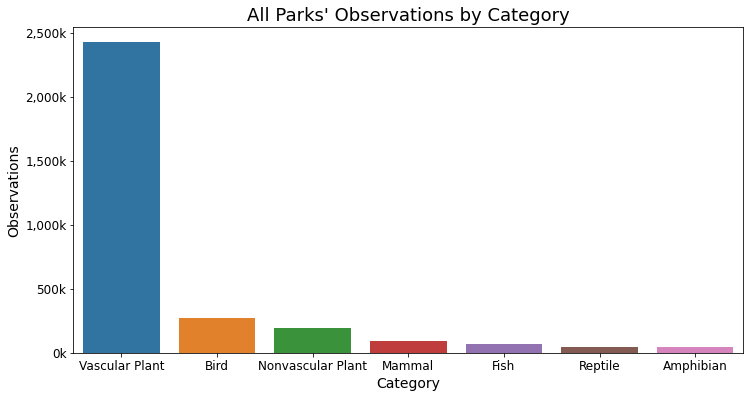

In [125]:
# sum observations by category
category_obs = bio_df.groupby('category')[['observations']].sum()

fig, ax = plt.subplots(figsize=(12, 6)) 
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data= category_obs, x=category_obs.index, y= 'observations', 
            order=category_obs.sort_values('observations', ascending= False).index)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))
plt.title('All Parks\' Observations by Category',fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Observations', fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig('Observations per Category.png', dpi= 600)

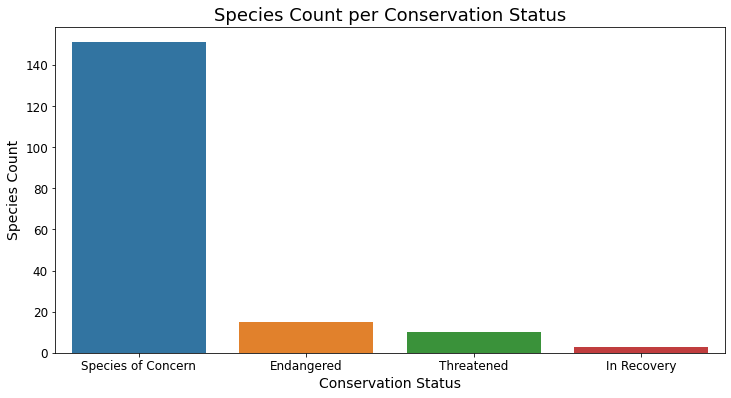

In [126]:
# count species by status
status_species_count = spec_df.loc[spec_df['conservation_status'] != 'None']
status_species_count = status_species_count.groupby('conservation_status')[['scientific_name']].count()
status_species_count

fig, ax = plt.subplots(figsize= (12, 6)) 
plt.ticklabel_format(style= 'plain', axis= 'y')
sns.barplot(data= status_species_count, x= status_species_count.index, y= 'scientific_name', 
            order= status_species_count.sort_values('scientific_name', ascending= False).index)
plt.title('Species Count per Conservation Status',fontsize=18)
plt.xlabel('Conservation Status', fontsize= 14)
plt.ylabel('Species Count', fontsize= 14)
plt.xticks(fontsize= 12);
plt.yticks(fontsize= 12);
plt.savefig('Species Count per Conservation Status.png', dpi= 600)

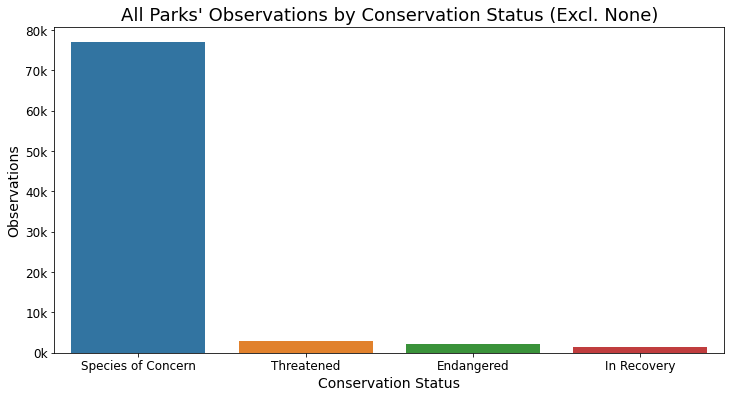

In [127]:
# sum observations by conservation status
status_obs = bio_df.loc[bio_df['conservation_status'] != 'None']
status_obs = status_obs.groupby('conservation_status')[['observations']].sum()
status_obs

fig, ax = plt.subplots(figsize=(12, 6)) 
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data= status_obs, x=status_obs.index, y= 'observations', 
            order=status_obs.sort_values('observations', ascending= False).index)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))
plt.title('All Parks\' Observations by Conservation Status (Excl. None)',fontsize=18)
plt.xlabel('Conservation Status', fontsize=14)
plt.ylabel('Observations', fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig('All Parks\' Observations by Conservation Status (Excl. None).png', dpi= 600)

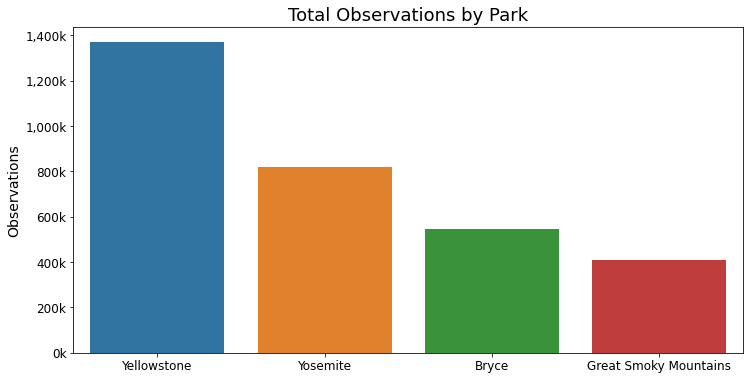

In [128]:
# sum observations by park
park_obs = bio_df.groupby('park_name')[['observations']].sum()

park_obs.index = ['Bryce', 'Great Smoky Mountains', 'Yellowstone', 'Yosemite']

fig, ax = plt.subplots(figsize=(12, 6)) 
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data= park_obs, x=park_obs.index, y= 'observations', 
            order= park_obs.sort_values('observations', ascending= False).index)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))
plt.title('Total Observations by Park',fontsize=18)
plt.ylabel('Observations', fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig('Total Observations by Park.png', dpi= 600)

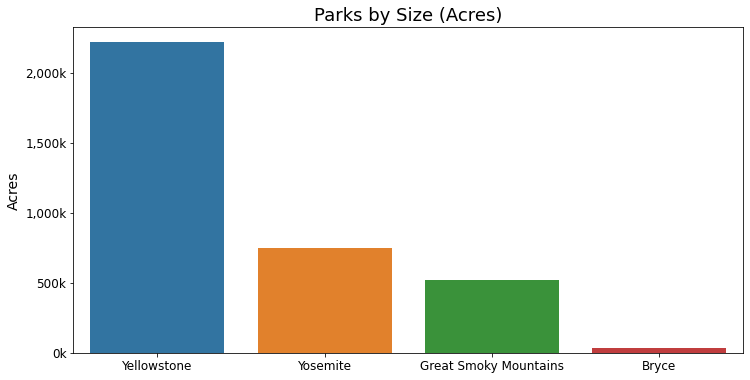

In [129]:
# create a df of the park acreage for 'diversity' plot
park_acres = {'acres': [35835, 522427, 2219791, 747956]}
park_labels = ['Bryce', 'Great Smoky Mountains', 'Yellowstone', 'Yosemite']
park_size = pd.DataFrame(park_acres, index= park_labels)
park_size.index.name = 'park_name'

fig, ax = plt.subplots(figsize= (12, 6)) 
plt.ticklabel_format(style= 'plain', axis= 'y')
sns.barplot(data= park_size, x= park_size.index, y= 'acres', 
            order= park_size.sort_values('acres', ascending= False).index)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k'))
plt.title('Parks by Size (Acres)',fontsize=18)
plt.ylabel('Acres', fontsize= 14)
plt.xlabel('')
plt.xticks(fontsize= 12);
plt.yticks(fontsize= 12);
plt.savefig('Parks by Size (Acres).png', dpi= 600)

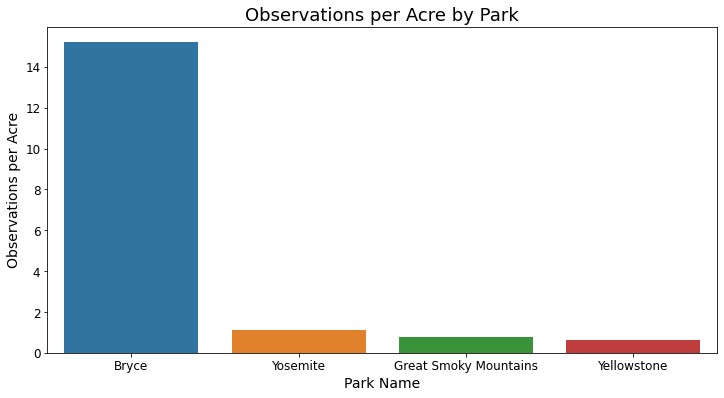

In [130]:
# plot observations per acre across parks
obs_per_acre = pd.merge(park_obs, park_size, left_index=True, right_index=True)
obs_per_acre['observations_per_acre'] = obs_per_acre['observations'] / obs_per_acre['acres']
obs_per_acre.index = ['Bryce', 'Great Smoky Mountains', 'Yellowstone', 'Yosemite']

fig, ax = plt.subplots(figsize= (12, 6)) 
plt.ticklabel_format(style= 'plain', axis= 'y')
sns.barplot(data= obs_per_acre, x= obs_per_acre.index, y= 'observations_per_acre', 
            order= obs_per_acre.sort_values('observations_per_acre', ascending= False).index)
plt.title('Observations per Acre by Park',fontsize=18)
plt.xlabel('Park Name', fontsize= 14)
plt.ylabel('Observations per Acre', fontsize= 14)
plt.xticks(fontsize= 12);
plt.yticks(fontsize= 12);
plt.savefig('Observations per Acre by Park.png', dpi= 600)

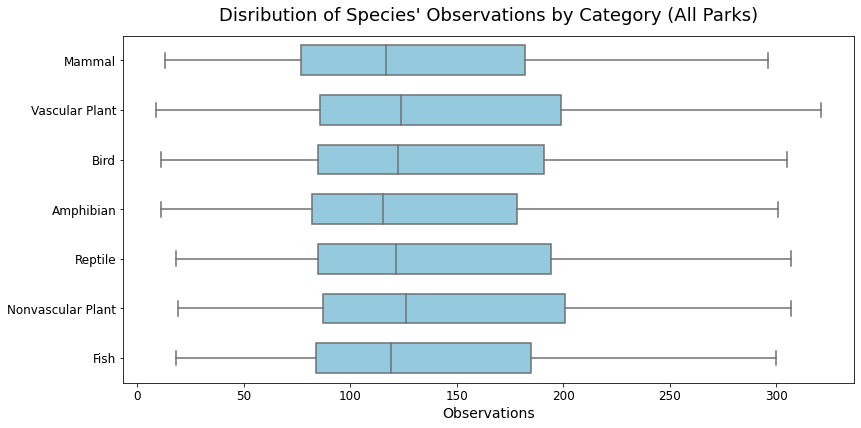

In [131]:
# Create a boxplot of observations on the x-axis, and categories on the y-axis

f, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(x= 'observations', y= 'category', data=bio_df, width=.6, color='skyblue')
plt.title('Disribution of Species\' Observations by Category (All Parks)', fontsize=18, y=1.025)
plt.xlabel('Observations', fontsize=14)
f.tight_layout()
plt.ylabel('')
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.savefig('Distribution of Species\' Observations by Category (All Parks).png', dpi= 600)

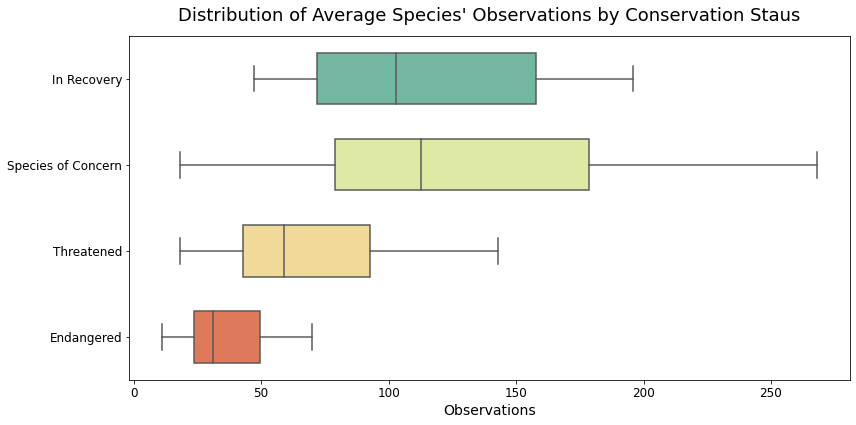

In [132]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x= 'observations', y= 'conservation_status', data=bio_df_troubled, width=.6, palette= 'Spectral_r');
plt.title('Distribution of Average Species\' Observations by Conservation Staus', fontsize=18, y=1.025);
plt.xlabel('Observations', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
fig.tight_layout()
plt.savefig('Distribution of Species\' Observations by Conservation Status.png', dpi= 600)

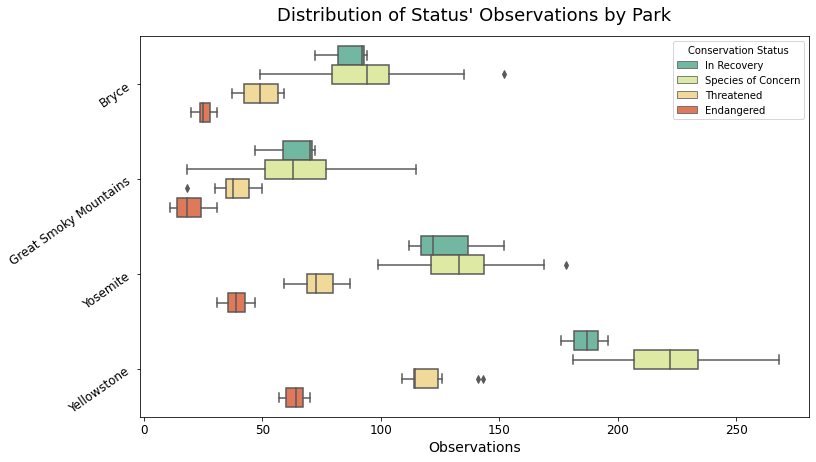

In [133]:
# plot boxplots of observations by status for each park

fig = plt.figure(figsize=(12, 7))
plt.subplots_adjust(hspace= 0.25, wspace= 0.30)
plt.title('Distribution of Status\' Observations by Park', fontsize=18, y=1.025)

# filter df and plot each status's observations by plot on the new subplot axes
ax = sns.boxplot(data= bio_df_troubled_renamed_parks, x= 'observations', y= 'park_name', hue= 'conservation_status', width= 0.8, palette= 'Spectral_r')

# formatting the figures & plots
ax.set_ylabel('')
ax.set_xlabel('')
plt.xlabel('Observations', fontsize=14)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.yticks(rotation = 35)
plt.legend(title= 'Conservation Status')

plt.savefig('All Parks\' Status Distributions.png', dpi= 600, bbox_inches='tight')

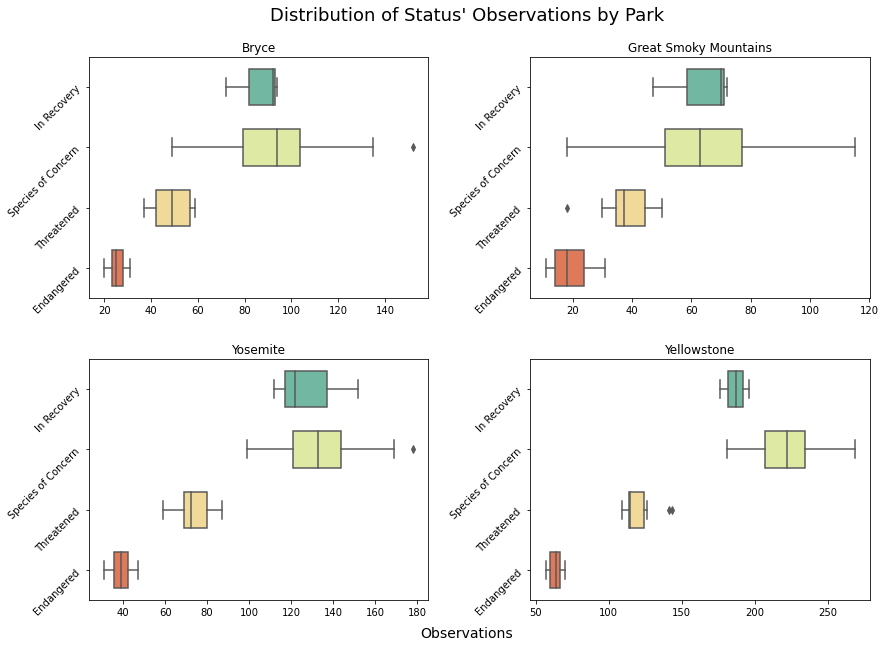

In [134]:
# plot boxplots of observations by status for each park

# define unique statuses for loop
parks = bio_df_troubled_renamed_parks['park_name'].unique()

fig = plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace= 0.25, wspace= 0.30)
plt.suptitle('Distribution of Status\' Observations by Park', fontsize=18, y=0.95)
fig.text(0.5,0.08, 'Observations', ha="center", va='center', fontsize=14)

# loop through the length of statuses and keep track of index
for n, park in enumerate(parks):
    # add a new subplot iteratively
    ax = plt.subplot(2, 2, n + 1)

    # filter df and plot each status's observations by plot on the new subplot axes
    bio_df_park = bio_df_troubled_renamed_parks.loc[(bio_df_troubled_renamed_parks.park_name == park)]
    sns.boxplot(data= bio_df_park, x= 'observations', y= 'conservation_status', width= 0.6, order= ['In Recovery',
                                                                                            'Species of Concern',
                                                                                            'Threatened',
                                                                                            'Endangered'], palette= 'Spectral_r')

    # formatting the figures & plots
    ax.set_title(park.title())
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation = 45)

plt.savefig('Distribution of Status\' Observations by Park.png', dpi= 600)

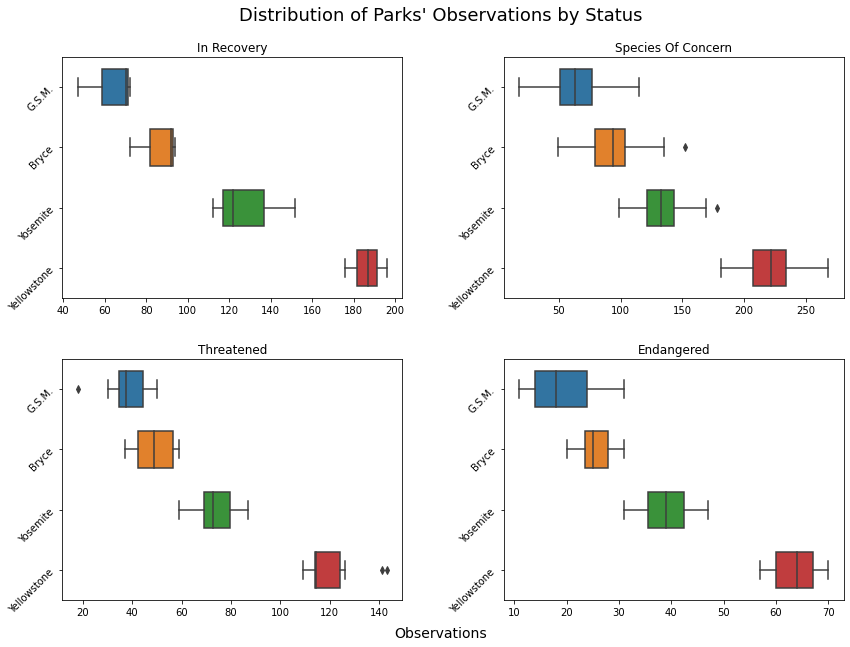

In [135]:
# plot boxplots of observations by park for each status

bio_df_troubled_renamed_parks_short = bio_df_troubled.replace({'Bryce National Park': 'Bryce', 
                                                         'Great Smoky Mountains National Park': 'G.S.M.', 
                                                         'Yosemite National Park': 'Yosemite', 
                                                         'Yellowstone National Park': 'Yellowstone'})

# define unique statuses for loop
statuses = bio_df_troubled_renamed_parks_short['conservation_status'].unique()

fig = plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace= 0.25, wspace= 0.30)
plt.suptitle('Distribution of Parks\' Observations by Status', fontsize=18, y=0.95)
fig.text(0.5,0.08, 'Observations', ha= 'center', va= 'center', fontsize=14)

# loop through the length of statuses and keep track of index
for n, status in enumerate(statuses):
    # add a new subplot iteratively
    ax = plt.subplot(2, 2, n + 1)

    # filter df and plot each status's observations by plot on the new subplot axes
    bio_df_status = bio_df_troubled_renamed_parks_short.loc[(bio_df_troubled_renamed_parks.conservation_status == status)]
    sns.boxplot(data= bio_df_status, x= 'observations', y= 'park_name', width= 0.6, order= ['G.S.M.', 'Bryce', 'Yosemite', 'Yellowstone'])

    # formatting the figures & plots
    ax.set_title(status.title())
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation = 45)
#     ax.tick_params(axis='x', which='major', labelsize=9)

# plt.tight_layout()
plt.savefig('Distribution of Parks\' Observations by Status', dpi= 600)

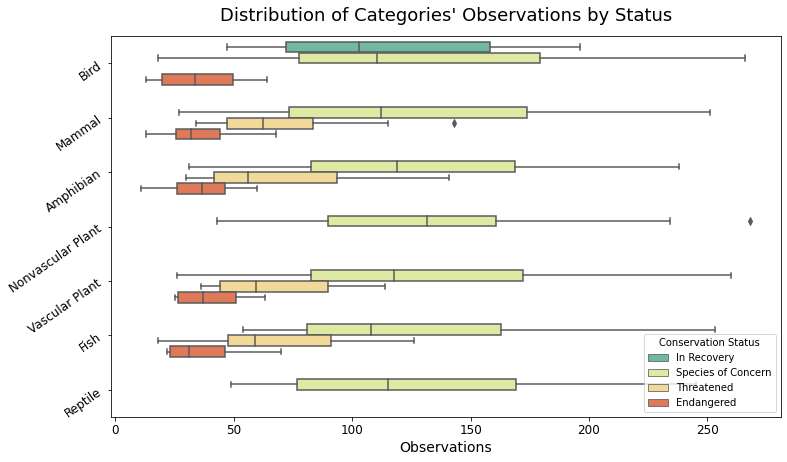

In [136]:
# plot boxplots of observations by status for each species category

fig = plt.figure(figsize=(12, 7))
plt.subplots_adjust(hspace= 0.25, wspace= 0.30)
plt.title('Distribution of Categories\' Observations by Status', fontsize=18, y=1.025)

# filter df and plot each status's observations by plot on the new subplot axes
ax = sns.boxplot(data= bio_df_troubled_renamed_parks, x= 'observations', y= 'category', hue= 'conservation_status', width= 0.8, palette= 'Spectral_r')

# formatting the figures & plots
ax.set_ylabel('')
ax.set_xlabel('')
plt.xlabel('Observations', fontsize=14)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.yticks(rotation = 35)
plt.legend(title= 'Conservation Status')

plt.savefig('Distribution of Categories\' Observations by Status.png', dpi= 600, bbox_inches='tight')

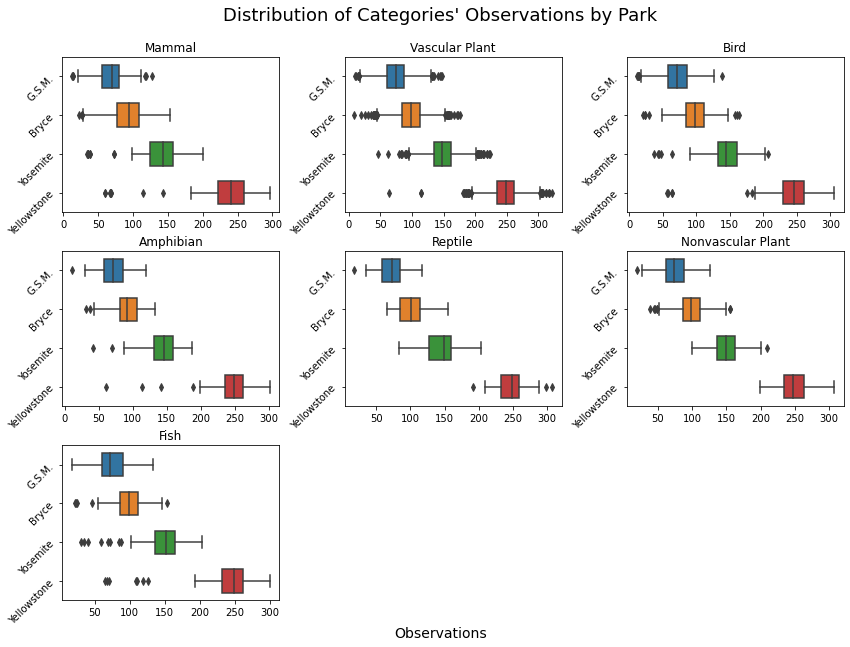

In [137]:
# plot boxplots category  observations for each park

bio_df_short = bio_df.replace({'Bryce National Park': 'Bryce',
                               'Great Smoky Mountains National Park': 'G.S.M.',
                               'Yosemite National Park': 'Yosemite',
                               'Yellowstone National Park': 'Yellowstone'})

# define unique statuses for loop
categories = bio_df['category'].unique()

fig = plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace= 0.25, wspace= 0.30)
plt.suptitle('Distribution of Categories\' Observations by Park', fontsize=18, y=0.95)
fig.text(0.5,0.08, 'Observations', ha="center", va='center', fontsize=14)

# loop through the length of statuses and keep track of index
for n, category in enumerate(categories):
    # add a new subplot iteratively
    ax = plt.subplot(3, 3, n + 1)

    # filter df and plot each status's observations by plot on the new subplot axes
    bio_df_category = bio_df_short.loc[(bio_df.category == category)]
    sns.boxplot(data= bio_df_category, x= 'observations', y= 'park_name', width= 0.6, order= ['G.S.M.', 'Bryce', 'Yosemite', 'Yellowstone'])

    # formatting the figures & plots
    ax.set_title(category.title())
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation = 45)

plt.savefig('Distribution of Categories\' Observations by Park.png', dpi= 600)

In [138]:
# Species Count by Protected Category

In [139]:
# Percentage of Protection by Category

In [ ]:
# Explore the possibility of a Chi-2 test.